In [280]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from PIL import Image
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import sklearn
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score

import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
import torch.optim as optim

In [281]:
df = pd.read_csv(os.path.join('./csv/', 'train_labels.csv'))
df

id  label
0       f38a6374c348f90b587e046aac6079959adf3835      0
1       c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2       755db6279dae599ebb4d39a9123cce439965282d      0
3       bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4       068aba587a4950175d04c680d38943fd488d6a9d      0
...                                          ...    ...
220020  53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6      0
220021  d4b854fe38b07fe2831ad73892b3cec877689576      1
220022  3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75      0
220023  f129691c13433f66e1e0671ff1fe80944816f5a2      0
220024  a81f84895ddcd522302ddf34be02eb1b3e5af1cb      1

[220025 rows x 2 columns]

In [282]:
print("Train Size: {}".format(len(os.listdir('./train/'))))
print("Test Size: {}".format(len(os.listdir('./test/')))) 

Train Size: 220026
Test Size: 57458


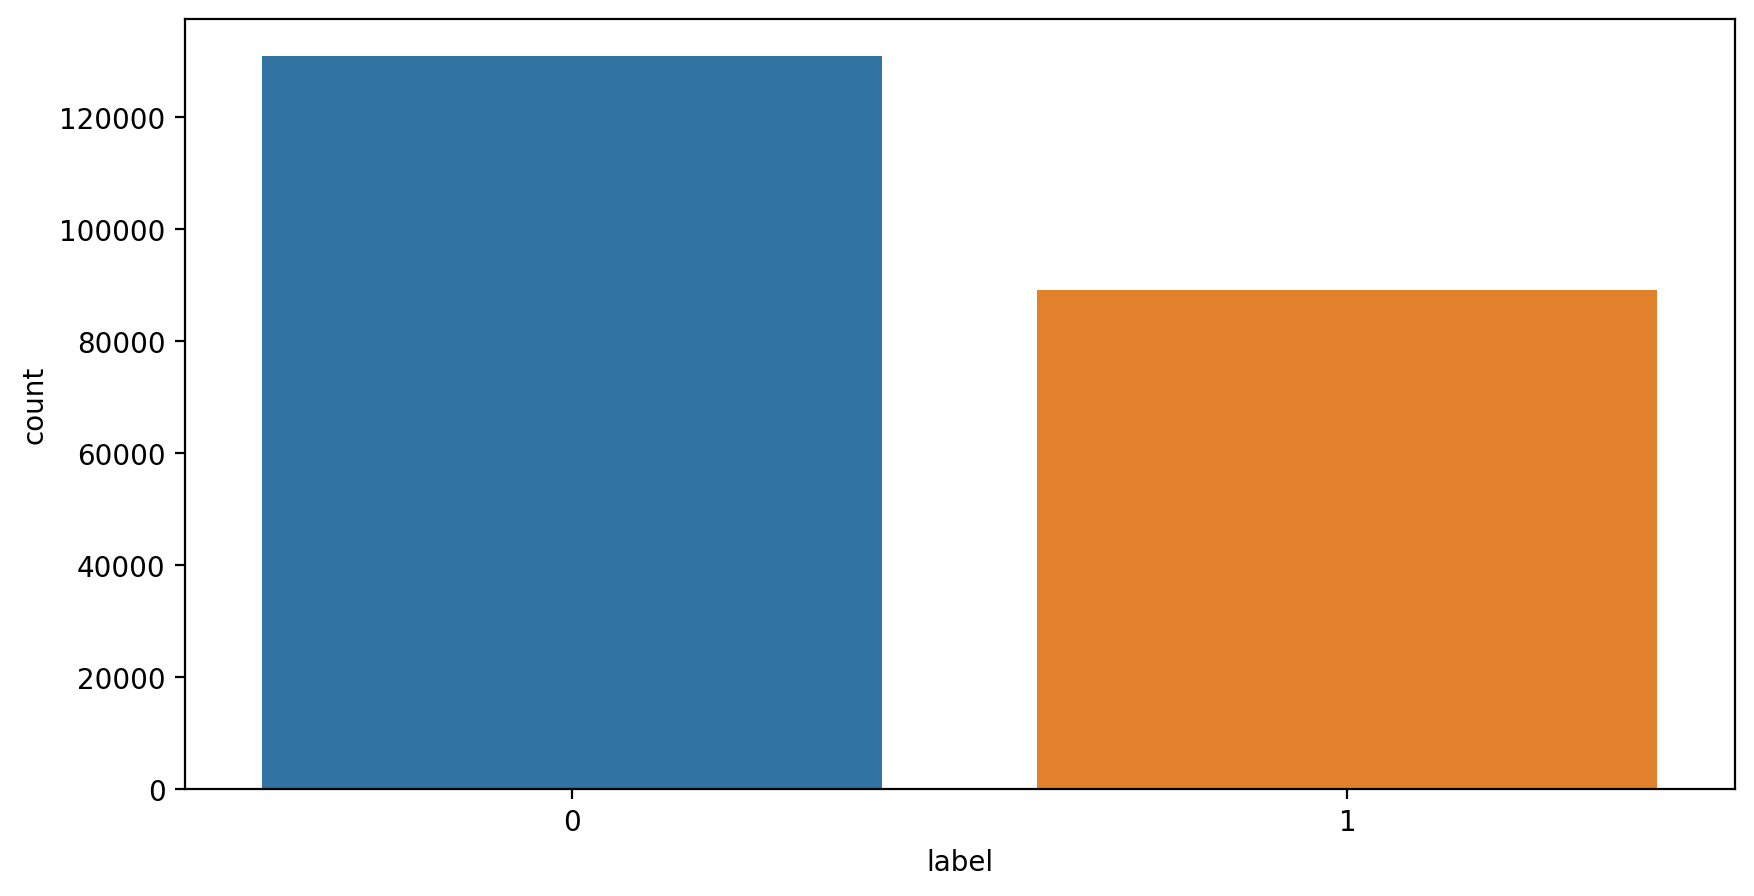

In [283]:
label_count =df.label.value_counts()
# Plot 1
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x = 'label', data= df)
plt.show()

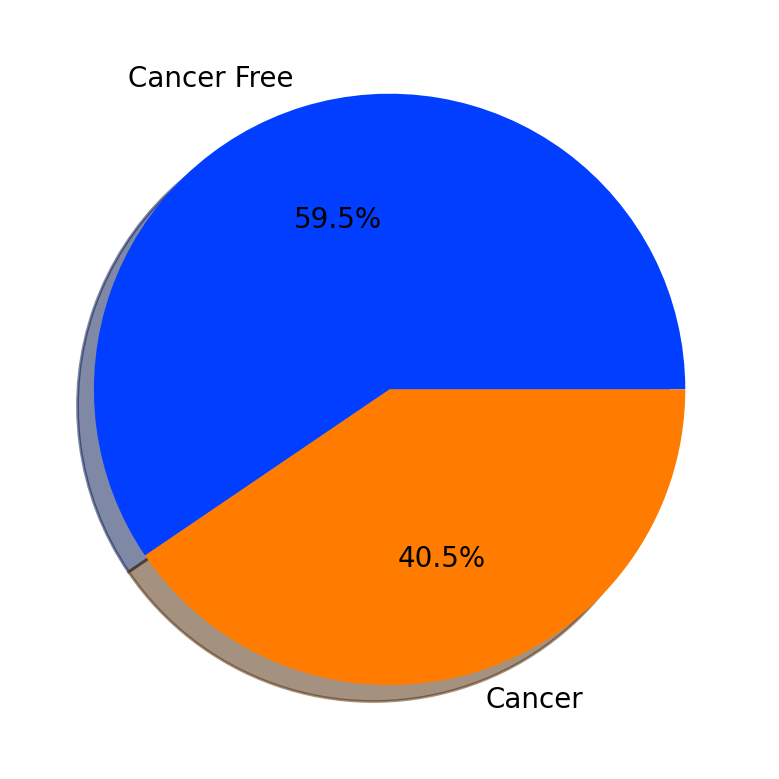

In [284]:
# plot 2
classes = ['Cancer Free', 'Cancer']
palette = sns.color_palette('bright')
plt.pie(label_count, labels=classes, colors=palette, autopct='%.1f%%', shadow = True)
plt.show()
# pie(x) -- x must be 1D array

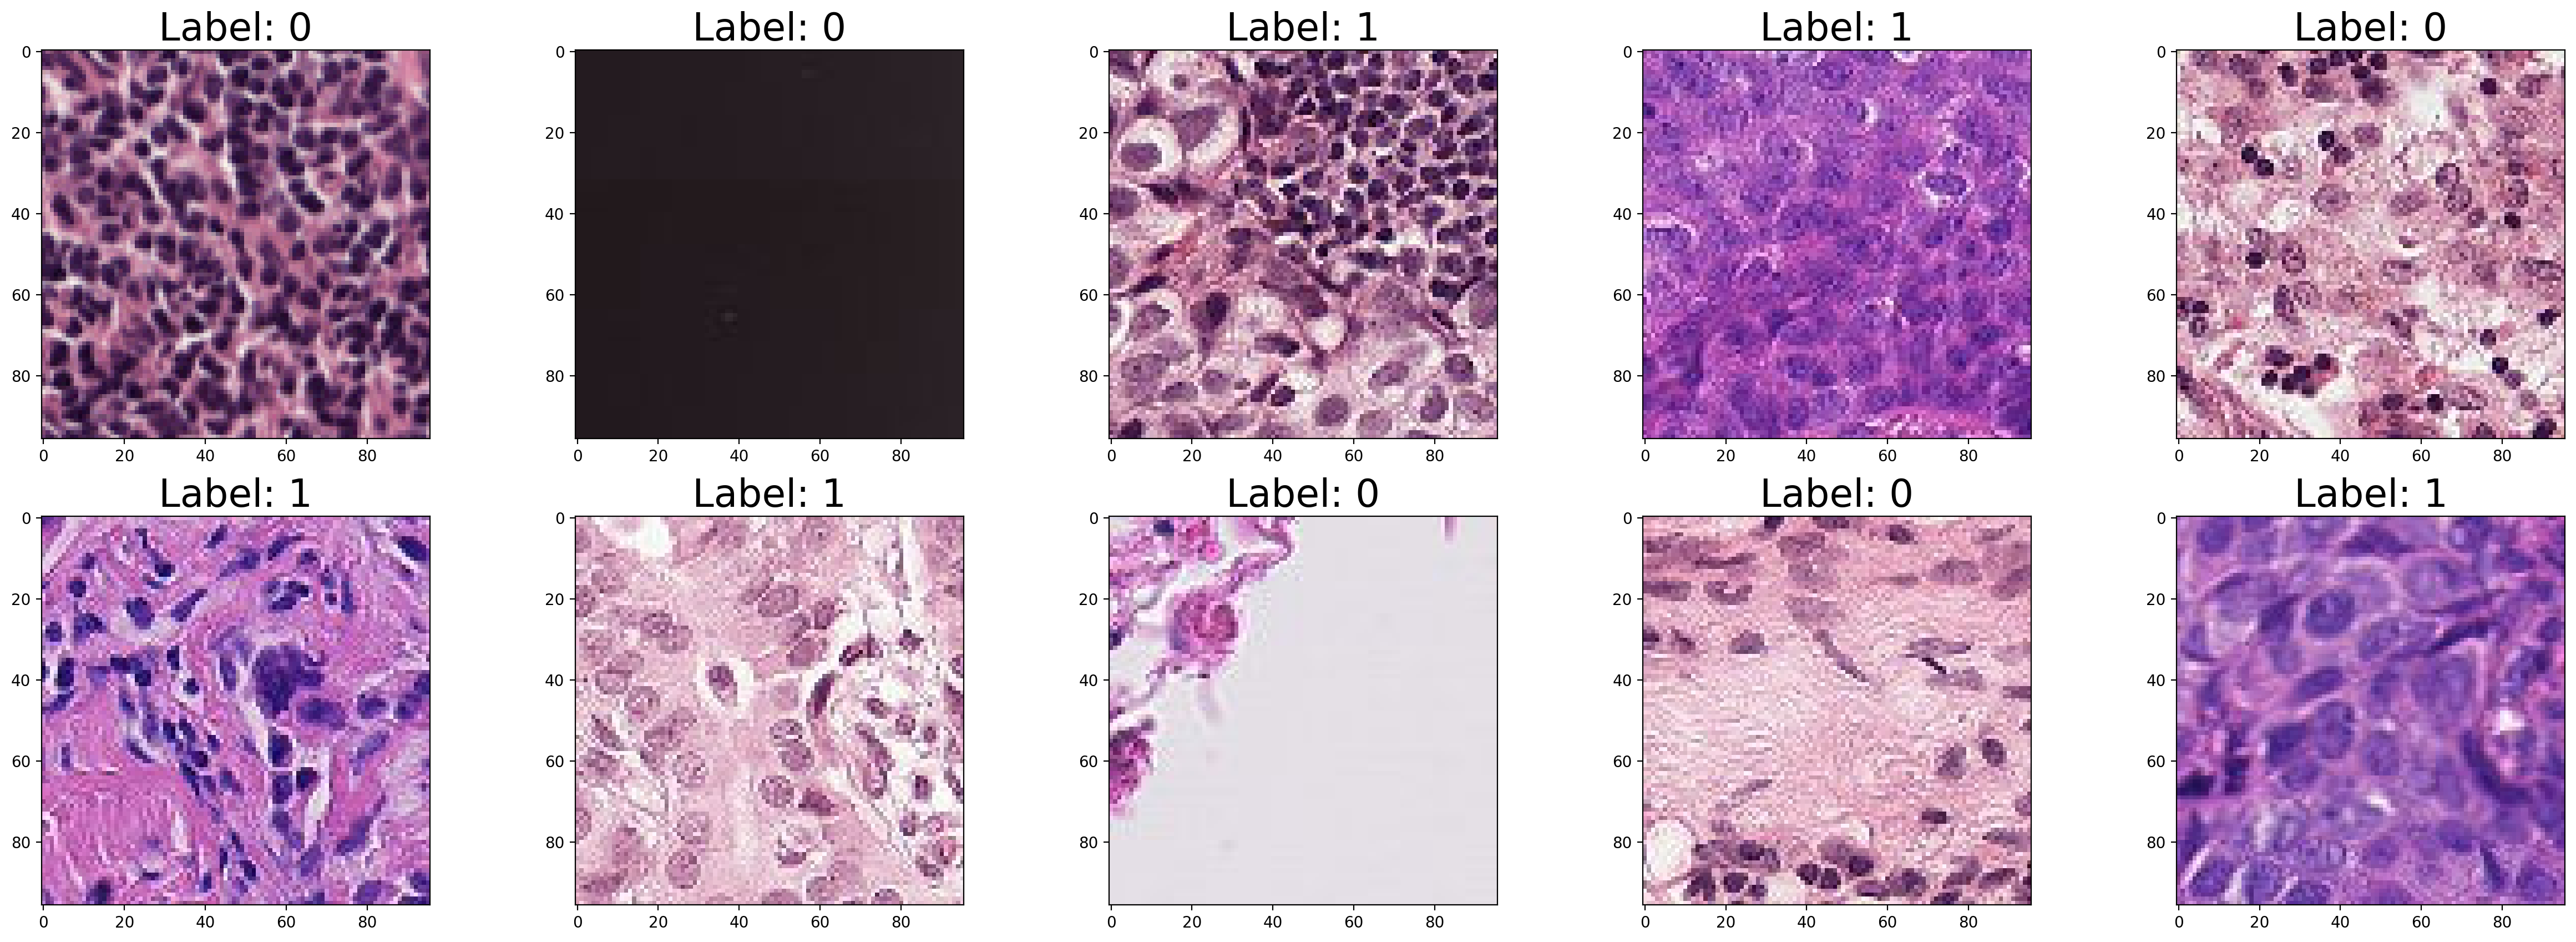

In [285]:
fig = plt.figure(figsize =(30, 10))
train_images = os.listdir('./train/')
for idx, img in enumerate(np.random.choice(train_images, 10)):
    ax = fig.add_subplot(2, 10//2, idx+1)
    im = Image.open('./train/' + img)
    plt.imshow(im)
    label = df.loc[df['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title('Label: %s'%label, fontsize = 25)

In [286]:
sample_size = 80000
train_data_path = './train/'
test_data_path = './test/'

df_neg = df[df['label'] == 0].sample(sample_size, random_state=42)
df_pos = df[df['label'] == 1].sample(sample_size, random_state=42)

In [287]:
df_neg, df_pos

(                                              id  label
 121450  941ffe73059292e0effd4e81ca9363c117afc2f4      0
 38268   43b6acadb31161c9281460efa3fad0b992a92837      0
 158080  64cfb56ddf41e2a871ac5164d61e50b238b9ed1b      0
 154803  9464cf403653088420cdb78acacd8cf7fa2255e4      0
 93791   346bc5b2d383d70dfccb8fe9102c7f55687f5f52      0
 ...                                          ...    ...
 59912   5e0a41926189cf176a0c46b3a8e6e57b7315b688      0
 216304  15f68316f33934196ce7d5b0537cb9154a5e1cc3      0
 40284   8df3f34c554ca5615d5e0d6e93990d5be5957036      0
 75788   4c7b14c1b6c7129e23c9f4a2c668bc8e4a1699b7      0
 158391  61900d35baaa2a6a53137c73f3b372bfa9f458bd      0
 
 [80000 rows x 2 columns],
                                               id  label
 200708  a9f7f612736ebf2fb47cd83ce0c368d3a480aeb2      1
 84162   c4f9ad1baf7755d52b2c37448ea3773c8520ee7d      1
 53336   ab999642f7ae64e93cb79607a32b7510784b2472      1
 146467  3a1b1d0b0a99d80be8918a366372d2b5adedb0c3      1
 1

In [288]:
main_df = sklearn.utils.shuffle(pd.concat([df_neg, df_pos], axis = 0).reset_index(drop = True))
main_df

id  label
6978    047ddb7a9bd94280259fdcf60c88adbc18a297de      0
26595   c049e359520e57298b15f7de2493d63b4787de72      0
41015   8f08d9f54eb5c63f3a67fd90be394640f7985038      0
45070   7aaa7bc9f3b187cbef5c537f1696a068fb900915      0
47192   24b265c92334835f71e89ceec88571108bf1dc2d      0
...                                          ...    ...
142693  7761b394d6a5949b2dbdb301f5f343dab0372df1      1
125737  ea7cec1517c917cc0d4b0faac88f8652f12cd63a      1
102262  e9f1ff041ad52d10241d2fde8c6c110ffed76234      1
138078  196557d114c9d3678ad8f08fa94939bdad2f1b2d      1
91878   e367ab6a0c497bc06316309653b2bfaf3668a937      1

[160000 rows x 2 columns]

In [236]:
class CreateDataset(Dataset):
    def __init__(self, data_df, data_dir = './', transform = None):
        super().__init__()
        self.df = data_df.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name, label = self.df[index]
        img_path = os.path.join(self.data_dir + img_name + '.tif')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [237]:
transform_img = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.70244707, 0.54624322, 0.69645334), (0.23889325, 0.28209431, 0.21625058))
])

In [238]:
train_data = CreateDataset(data_df = main_df, data_dir = train_data_path, transform = transform_img)

In [239]:
batch = 128
val_size = 0.1

num_train = len(train_data)
indices = list(range(num_train))

splits = int(np.floor(val_size * num_train))
train_idx, val_idx = indices[splits:], indices[:splits]

train_sample = SubsetRandomSampler(train_idx)
val_sample = SubsetRandomSampler(val_idx)

In [240]:
train_loader = DataLoader(train_data, batch_size=batch, sampler=train_sample)
valid_loader = DataLoader(train_data, batch_size=batch, sampler=val_sample)

In [241]:
transforms_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.70244707, 0.54624322, 0.69645334), (0.23889325, 0.28209431, 0.21625058))
])

# creating test data
sample_sub = pd.read_csv(os.path.join('./sample/', 'sample_submission.csv'))
test_data = CreateDataset(data_df=sample_sub, data_dir=test_data_path, transform=transforms_test)

# prepare the test loader
test_loader = DataLoader(test_data, batch_size=batch, shuffle=False)

In [242]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        # Convolutional and Pooling Layers
        self.conv1=nn.Sequential(
                nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=0),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv2=nn.Sequential(
                nn.Conv2d(in_channels=32,out_channels=64,kernel_size=2,stride=1,padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv3=nn.Sequential(
                nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv4=nn.Sequential(
                nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv5=nn.Sequential(
                nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))

        self.dropout2d = nn.Dropout2d()
        
        
        self.fc=nn.Sequential(
                nn.Linear(512*3*3,1024),
                nn.ReLU(inplace=True),
                nn.Dropout(0.4),
                nn.Linear(1024,512),
                nn.Dropout(0.4),
                nn.Linear(512, 1),
                nn.Sigmoid())
        
    def forward(self,x):
        """Method for Forward Prop"""
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x=self.conv5(x)
        x=x.view(x.shape[0],-1)
        x=self.fc(x)
        return x

In [243]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [244]:
model = CNN()
print(model)

# Move model to GPU if available
if train_on_gpu: model.cuda()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [245]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(total_params))

Number of trainable parameters: 
6805249


In [248]:
criterion = nn.BCEWithLogitsLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00015)

In [249]:
n_epochs = 20

valid_loss_min = np.Inf

# keeping track of losses as it happen
train_losses = []
valid_losses = []
val_auc = []
test_accuracies = []
valid_accuracies = []
auc_epoch = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda().float()
        target = target.view(-1, 1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # Update Train loss and accuracies
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda().float()
        # forward pass: compute predicted outputs by passing inputs to the model
        target = target.view(-1, 1)
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        #output = output.topk()
        y_actual = target.data.cpu().numpy()
        y_pred = output[:,-1].detach().cpu().numpy()
        val_auc.append(roc_auc_score(y_actual, y_pred))        
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    valid_auc = np.mean(val_auc)
    auc_epoch.append(np.mean(val_auc))
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} | Training Loss: {:.6f} | Validation Loss: {:.6f} | Validation AUC: {:.4f}'.format(
        epoch, train_loss, valid_loss, valid_auc))
    
    ##################
    # Early Stopping #
    ##################
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'best_model.pt')
        valid_loss_min = valid_loss

Epoch: 1 | Training Loss: 0.589120 | Validation Loss: 0.579048 | Validation AUC: 0.8809
Validation loss decreased (inf --> 0.579048).  Saving model ...
Epoch: 2 | Training Loss: 0.585614 | Validation Loss: 0.584964 | Validation AUC: 0.8730
Epoch: 3 | Training Loss: 0.583616 | Validation Loss: 0.580970 | Validation AUC: 0.8733
Epoch: 4 | Training Loss: 0.583064 | Validation Loss: 0.576113 | Validation AUC: 0.8705
Validation loss decreased (0.579048 --> 0.576113).  Saving model ...
Epoch: 5 | Training Loss: 0.582935 | Validation Loss: 0.573884 | Validation AUC: 0.8699
Validation loss decreased (0.576113 --> 0.573884).  Saving model ...
Epoch: 6 | Training Loss: 0.580666 | Validation Loss: 0.575181 | Validation AUC: 0.8700
Epoch: 7 | Training Loss: 0.582596 | Validation Loss: 0.582324 | Validation AUC: 0.8633
Epoch: 8 | Training Loss: 0.582155 | Validation Loss: 0.576442 | Validation AUC: 0.8622
Epoch: 9 | Training Loss: 0.581115 | Validation Loss: 0.581506 | Validation AUC: 0.8610
Epoch:

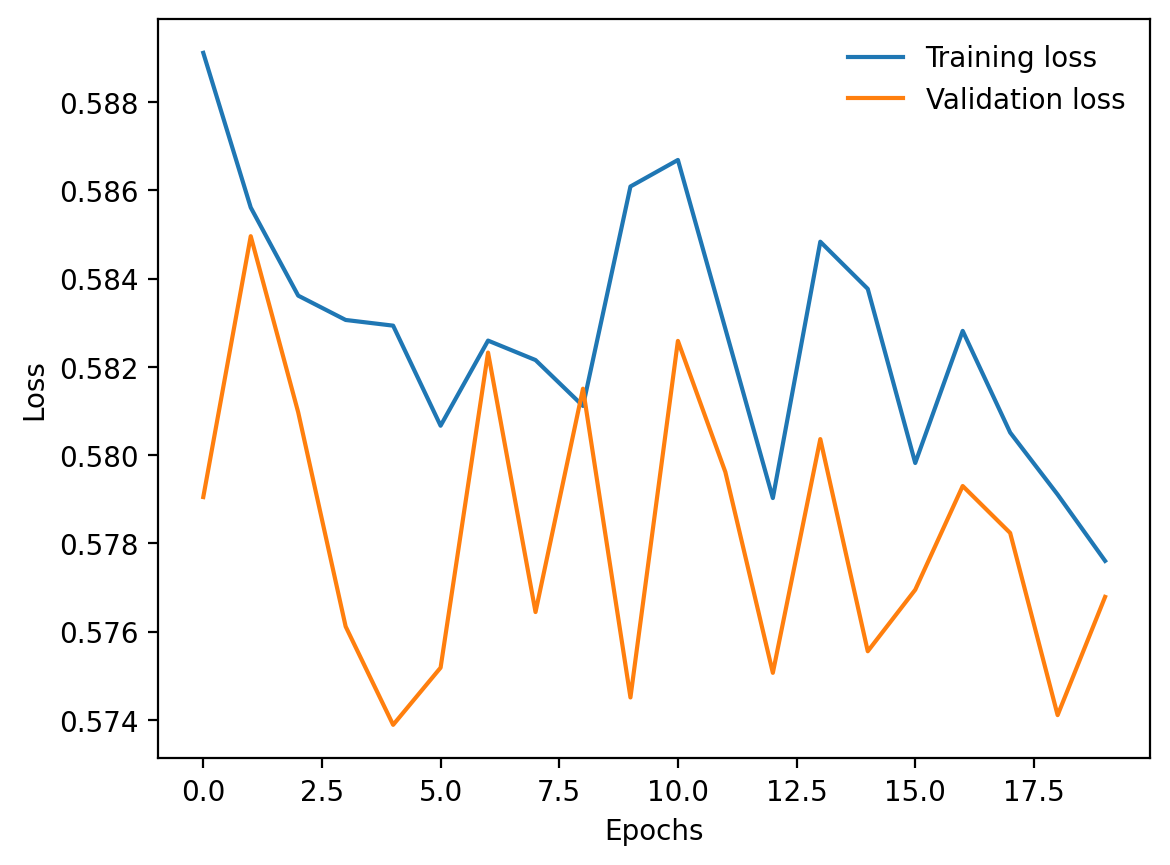

In [250]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

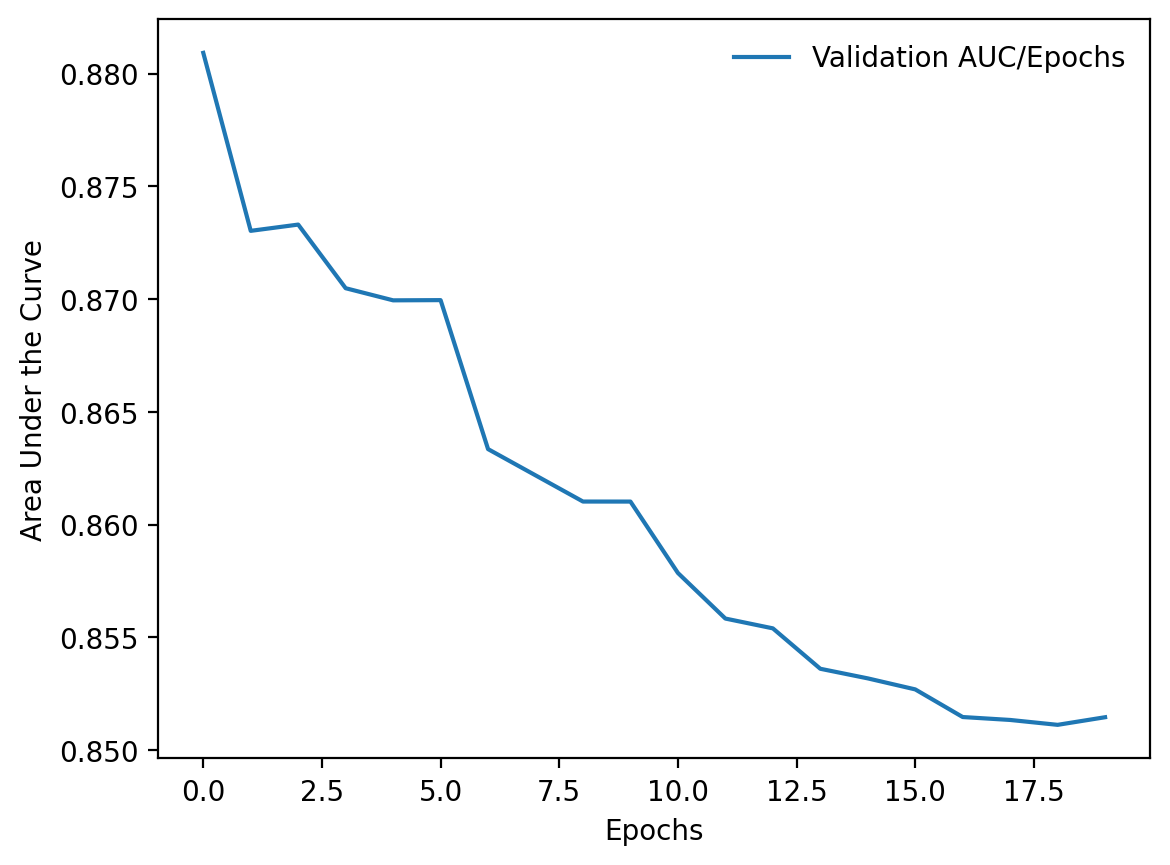

In [251]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(auc_epoch, label='Validation AUC/Epochs')
plt.legend("")
plt.xlabel("Epochs")
plt.ylabel("Area Under the Curve")
plt.legend(frameon=False)



In [252]:
model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

In [253]:
model.eval()

preds = []
for batch_i, (data, target) in enumerate(test_loader):
    data, target = data.cuda(), target.cuda()
    output = model(data)

    pr = output.detach().cpu().numpy()
    for i in pr:
        preds.append(i)

# Create Submission file        
sample_sub['label'] = preds

In [254]:
for i in range(len(sample_sub)):
    sample_sub.label[i] = np.float(sample_sub.label[i]) 

sample_sub.to_csv('submission.csv', index=False)
sample_sub.head()

id label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5   0.0
1  95596b92e5066c5c52466c90b69ff089b39f2737   1.0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914   0.0
3  2c35657e312966e9294eac6841726ff3a748febf   0.0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6   0.0

In [255]:
def imshow(img):
    '''Helper function to un-normalize and display an image'''
    # unnormalize
    img = img / 2 + 0.5
    # convert from Tensor image and display
    plt.imshow(np.transpose(img, (1, 2, 0)))



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

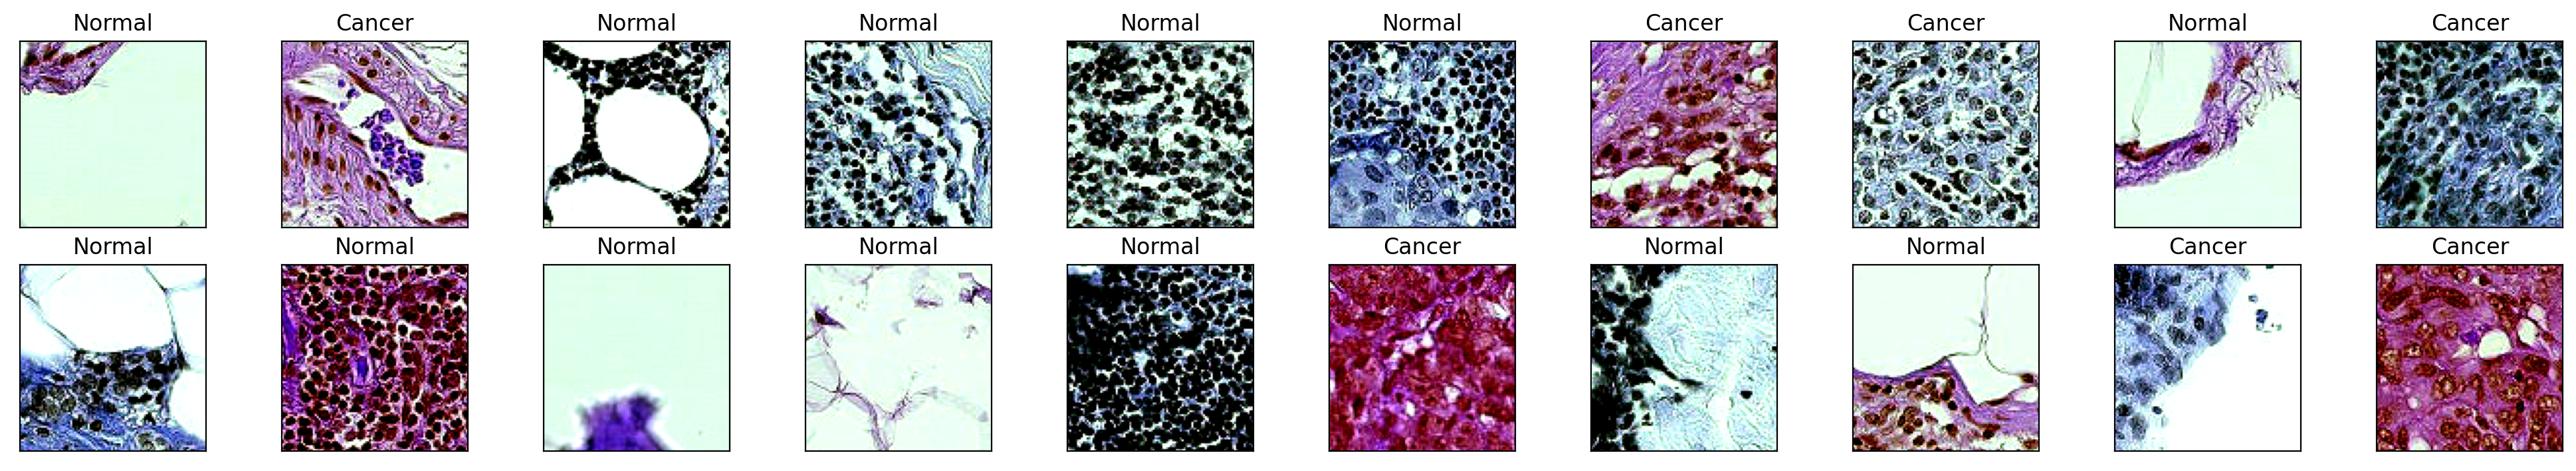

In [258]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    prob = "Cancer" if(sample_sub.label[idx] >= 0.5) else "Normal" 
    ax.set_title('{}'.format(prob))

    Its not a perfect model, but still an auucary of 85 is not bad either. We can try other parameters to see how it works
    or train a new model again